## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度

In [1]:
## 確認硬體資源
!nvidia-smi

Tue Feb 12 00:44:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.93       Driver Version: 410.93       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 34%   59C    P2    84W / 250W |  10367MiB / 11178MiB |     18%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 23%   29C    P8    16W / 250W |  11177MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
import keras

# 啟用 GPU, 將 GPU 設定在有空檔的 GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # 設定 smi 看到的 GPU ID 符合實際設定的順序 (若一台機器有多張不同型號的卡時，會有此類問題)
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [4]:
"""Code Here
資料前處理
"""
def preproc_x(x, flatten=True):
    x = 2*(((x - x.min()) / (x.max() - x.min()))-0.5)
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
"""Code Here
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 128, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 128)               16512     
_________________________________________________________________
hidden_layer5 (Dense)        (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total para

In [8]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [9]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [10]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 120us/step - loss: 1.6952 - acc: 0.3959 - val_loss: 1.5441 - val_acc: 0.4500
Epoch 2/100
50000/50000 [==============================] - 2s 48us/step - loss: 1.4660 - acc: 0.4804 - val_loss: 1.4604 - val_acc: 0.4831
Epoch 3/100
50000/50000 [==============================] - 2s 49us/step - loss: 1.3487 - acc: 0.5232 - val_loss: 1.4204 - val_acc: 0.5011
Epoch 4/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.2546 - acc: 0.5591 - val_loss: 1.3956 - val_acc: 0.5112
Epoch 5/100
50000/50000 [==============================] - 3s 59us/step - loss: 1.1757 - acc: 0.5853 - val_loss: 1.3733 - val_acc: 0.5214
Epoch 6/100
50000/50000 [==============================] - 3s 59us/step - loss: 1.0965 - acc: 0.6112 - val_loss: 1.3694 - val_acc: 0.5204
Epoch 7/100
50000/50000 [==============================] - 3s 51us/step - loss: 1.0260 - acc: 0.6357 - val_loss: 1.3953 -

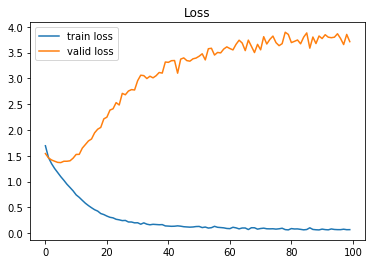

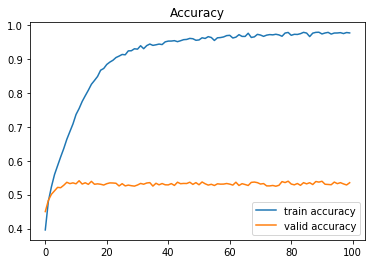

In [12]:
import matplotlib.pyplot as plt

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()